In [ ]:
import numpy as np
import QuantLib as ql
from src.QlMarket import QlMarket
from src.QlStockPricer import QlStockPricer
from src.QlVanillaOption import QlVanillaOption
import matplotlib.pyplot as plt



In [2]:
S0 = 100
strike = 100
r = 0.05
sigma = 0.3
T=1

In [3]:
start_date = ql.Date(1, 1, 2023)
qlMarket = QlMarket(init_date=start_date, init_risk_free_rate=r)
start_date = qlMarket.init_date
end_date = qlMarket.yearFractionToDate(start_date, 1)
start_date, end_date

(Date(3,1,2023), Date(10,1,2024))

In [4]:
qlMarket.calendar

<QuantLib.QuantLib.HongKong; proxy of <Swig Object of type 'QuantLib::HongKong *' at 0x10fd2b840> >

In [5]:
stock_1 = QlStockPricer(QlMarket=qlMarket, init_stock_price=S0)
stock_1.using_Black_Scholes_model(sigma=sigma)


Next step, you need set model type
set new model: Black Scholes model with sigma: 0.3


In [6]:
stock_1.day_counter.yearFraction(start_date, end_date)

1.0

## compare option prices

### Quantlib

In [7]:
ql_call = QlVanillaOption.init_from_price_and_date(
    strike_price=strike,
    end_date=end_date,
    QlStockPricer = stock_1,
    option_type=ql.Option.Call,
    engine = ql.AnalyticEuropeanEngine
)
ql_put = QlVanillaOption.init_from_price_and_date(
    strike_price=strike,
    end_date=end_date,
    QlStockPricer = stock_1,
    option_type=ql.Option.Put,
    engine = ql.AnalyticEuropeanEngine
)
print(f'call: {ql_call.NPV()}')
print(f'put: {ql_put.NPV()}')
print(f'call - put : {ql_call.NPV() - ql_put.NPV()}')
print(ql_call.NPV() - ql_put.NPV() - (S0 - strike * np.exp(-r * T)))

call: 14.231254785985845
put: 9.354197236057235
call - put : 4.87705754992861
1.5987211554602254e-14


### python code

In [8]:
from scipy.stats import norm

def bs_option(S0, strike, T, r, sigma, type):
    '''
    Black-Scholes option pricing formula

    Parameters
    ----------
    S0 : float
        Initial value of the underlying
    strike : float
        Strike price of the option
    T : float
        Time to maturity of the option
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the underlying
    type : str
        Type of option, either 'call' or 'put'
    '''
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == 'call':
        return S0 * norm.cdf(d1) - strike * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'put':
        return strike * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError('Option type must be either "call" or "put"')

# test if fulfills put-call parity
call = bs_option(S0, strike, T, r, sigma, 'call')
put = bs_option(S0, strike, T, r, sigma, 'put')

print(f'call: {call}')
print(f'put: {put}')
print(f'call - put : {call - put}')
print(call - put - (S0 - strike * np.exp(-r * T)))

call: 14.231254785985819
put: 9.354197236057232
call - put : 4.877057549928587
-7.105427357601002e-15


## compare delta

### Quantlib

In [9]:
call_delta = ql_call.delta()
put_delta = ql_put.delta()

print(call_delta)
print(put_delta)
print(call_delta - put_delta)

0.6242517279060127
-0.3757482720939874
1.0


### python code

In [10]:
def bs_delta(S0, strike, T, r, sigma, type):
    '''
    Black-Scholes delta

    Parameters
    ----------
    S0 : float
        Initial value of the underlying
    strike : float
        Strike price of the option
    T : float
        Time to maturity of the option
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the underlying
    type : str
        Type of option, either 'call' or 'put'
    '''
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    if type == 'call':
        return norm.cdf(d1)
    elif type == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError('Option type must be either "call" or "put"')

call_delta = bs_delta(S0, strike, T, r, sigma, 'call')
put_delta = bs_delta(S0, strike, T, r, sigma, 'put')

print(call_delta)
print(put_delta)
print(call_delta - put_delta)

0.6242517279060125
-0.37574827209398753
1.0


## stock path

In [11]:
steps = qlMarket.day_counter.dayCount(start_date, end_date)
dt =  1 / steps
M = 10
dt

0.003968253968253968

### Quantlib
### 循环会慢些

In [12]:
stock_path_generator1 = stock_1.create_stock_path_generator(steps)
ql_stock_path = [np.array(stock_path_generator1.next().value()) for _ in range(M)]
ql_stock_path = np.array(ql_stock_path)

使用步数: 252 步
timesteps: 252, Time length(per year): 1.0start_date: January 3rd, 2023 end_date: January 10th, 2024


In [23]:
ql_stock_path = np.array(ql_stock_path)
ql_stock_path = ql_stock_path.T
ql_stock_path.shape

(253, 1000)

In [25]:
ql_stock_path[-1].mean(), ql_stock_path[-1].var()

(104.5334253616648, 947.8683048654799)

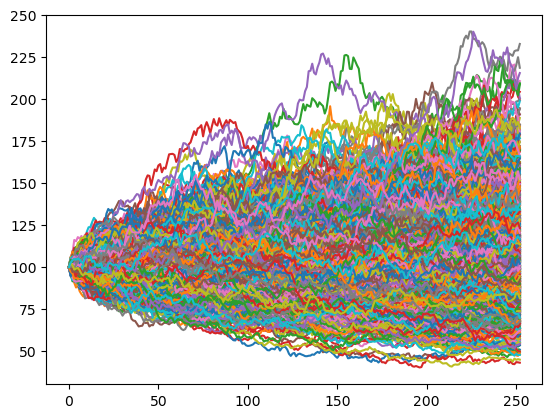

In [26]:
plt.plot(ql_stock_path)

### python code

In [16]:
def brownian(T, dt, M):
    ''' 
    Generate a brownian path with from 0 to T with time step dt
    
    Based on:
        X(t+dt) = X(t) + N(0, delta**2 * dt)

    Code adapted from:
    "https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html"

    Parameters
    ----------
    T : float
        Final time of the brownian path
    dt : float
        Time step of the brownian path
    M : int
        Number of paths to generate
    '''

    K = int(T/dt)
    X = np.zeros((M, K+1))

    # Create the increments of the brownian motion
    r = norm.rvs(size=(M, K), scale=np.sqrt(dt))
    
    # Cumulative sum of the random numbers
    X[:, 1:] = np.cumsum(r, axis=1)

    return X.T

def geometric_brownian_motion(x0, T, dt, sigma, mu, M):
    brownian_path = brownian(T, dt, M)
    return x0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * brownian_path)

In [17]:
stock_path = geometric_brownian_motion(S0, T, dt, sigma, r, M)

In [22]:
stock_path.shape

(253, 1000)

In [18]:
stock_path[-1].mean(), stock_path[-1].var()

(104.9175138639846, 1079.028304419154)

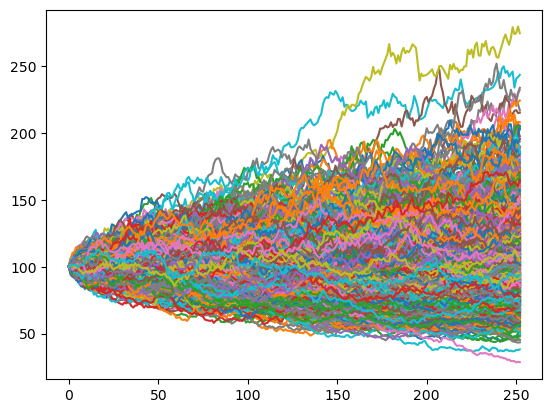

In [19]:
plt.plot(stock_path)

## Compare options and pnl
### we use stock_price

## QuantLib

In [1]:
# Generate the initial option price
ql_option_price = ql_call.NPV()

# Generate the initial delta
initial_delta = ql_call.delta()

# Generate the cash account
cash = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_path.shape)

# PnL
pnl = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = ql_option_price * steps - initial_delta * S0

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - ql_option_price * steps + initial_delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = ql_option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = initial_delta

t = 1
while qlMarket.today <= end_date:
    # print(qlMarket.today)
    stock_price = stock_path[t]
    
    
    
    t += 1
    qlMarket.to_next_trading_date() 

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * M + initial_delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * dt)

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.show()

NameError: name 'ql_call' is not defined

## python code

/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_5899/3920319175.py:22: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_5899/2619663715.py:20: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


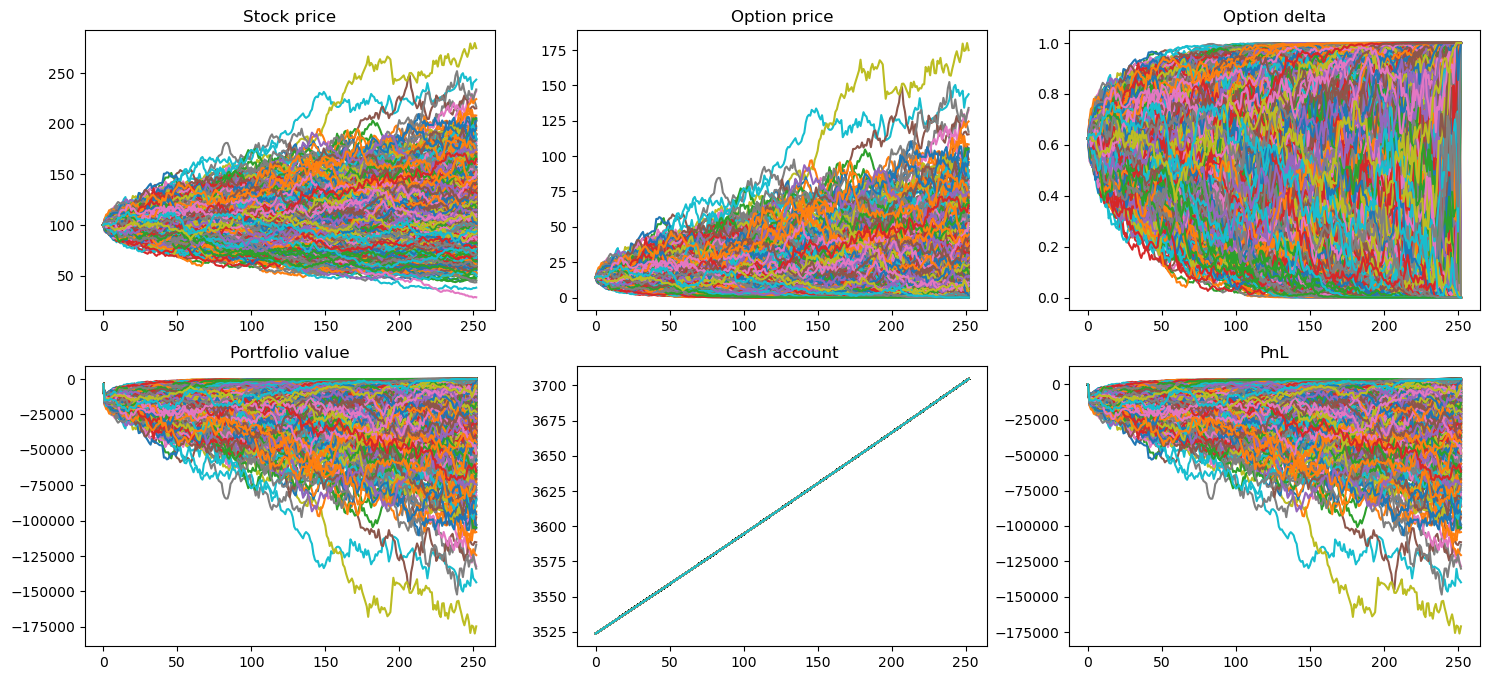

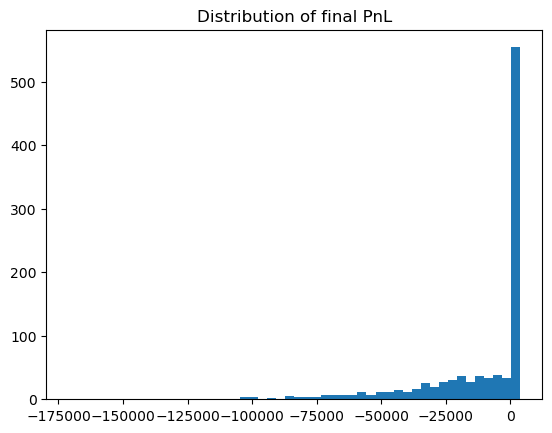

In [20]:
# Generate the initial option price
option_price = bs_option(S0, strike, T, r, sigma, 'call')

# Generate the initial delta
initial_delta = bs_delta(S0, strike, T, r, sigma, 'call')

# Generate the cash account
cash = np.zeros(stock_path.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_path.shape)

# PnL
pnl = np.zeros(stock_path.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = option_price * steps - initial_delta * S0

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - option_price * steps + initial_delta * S0

option_path = np.zeros(stock_path.shape)
option_path[0] = option_price
option_delta = np.zeros(stock_path.shape)
option_delta[0] = initial_delta

for t in range(1, len(stock_path)):
    # Update the stock price
    stock_price = stock_path[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, r, sigma, 'call')
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * M + initial_delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] * np.exp(r * dt)

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

# Plot the PnL, cash account and portfolio value
# Plot in separate figure the stock price and option price
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_path)
ax[0, 0].set_title('Stock price')

ax[0, 1].plot(option_path)
ax[0, 1].set_title('Option price')

ax[0, 2].plot(option_delta)
ax[0, 2].set_title('Option delta')

ax[1, 0].plot(portfolio)
ax[1, 0].set_title('Portfolio value')

ax[1, 1].plot(cash)
ax[1, 1].set_title('Cash account')

ax[1, 2].plot(pnl)
ax[1, 2].set_title('PnL')

plt.show()


# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.show()

In [21]:
stock_path.shape

(253, 1000)